In [85]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import wandb

In [86]:
from sine_data_generator import SineDataGenerator
from models.decoder import Decoder
from models.utils import ReluNet, make_leave_one_out
from models.encoder import DeterministicIOPairSetEncoder
from models.lpn import DeterministicLPN


In [87]:
np.random.seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_metaiter = 30_001
n_samples_per_task = 20
batch_size = 25
d_latent = 4

In [88]:

# Create encoder
encoder = DeterministicIOPairSetEncoder(
    phi=ReluNet(2, 16, 32),
    rho_0=ReluNet(32, 16, 16),
    rho_1=ReluNet(16, 8, d_latent)
)

# Create decoder
decoder = Decoder(
    d_input=1, 
    d_latent=d_latent, 
    ds_hidden=[16, 16, 16], 
    d_output=1
)

# Create the model
lpn = DeterministicLPN(
    d_input=1,
    d_output=1,
    d_latent=d_latent,
    encoder=encoder,
    decoder=decoder
).to(device)

# Create data generator for training
data_gen = SineDataGenerator(n_samples_per_task, batch_size)

In [89]:
# Training function
def train_deterministic_lpn(lpn, data_gen, device):
    wandb.init(project="deterministic_lpn4sine_cf_maml")
        
    n_metaiter = 30_001 
    n_samples_per_task = 20
    batch_size = 25
    numstep = 1
    d_latent = lpn.d_latent
    
    print("Total parameters:", sum(p.numel() for p in lpn.parameters()))
    
    optimizer = torch.optim.AdamW(lpn.parameters(), lr=1e-3)
    
    losses = []
    
    for i in range(n_metaiter):
        lpn.train()
        optimizer.zero_grad()
        
        xs, ys, amp, phase = data_gen.generate()
        io_pairs = torch.cat([xs, ys], dim=-1).to(device)  # (B, N, 2)
        
        _, loss = lpn(io_pairs, K=numstep, debug=(i==0))
        
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            wandb.log({"loss": loss.item()})
            losses.append(loss.item())
        if i % 1000 == 0:
            print(f"Step {i}, Loss: {loss.item():.4f}")
    
    # Save the model
    torch.save(lpn.state_dict(), f'deterministic_lpn_H{d_latent}_GA{numstep}.pth')
    wandb.finish()
    
    return losses

# Evaluation function
def evaluate_deterministic_lpn(lpn, device):
    n_test_points = 60
    test_batch_size = 1
    n_test_samples_per_task = 20
    n_support_samples_per_task = 10
    n_query_samples_per_task = n_test_samples_per_task - n_support_samples_per_task
    
    test_numstep = 10 #100
    data_gen = SineDataGenerator(n_test_samples_per_task, test_batch_size)
    
    
    metaeval_losses = np.full((n_test_points, test_numstep + 1), np.nan)
    
    for i_test_task in range(n_test_points):
        test_xs, test_ys, amp, phase = data_gen.generate()
        support_xs = test_xs[:, :n_support_samples_per_task, :]
        support_ys = test_ys[:, :n_support_samples_per_task, :]
        query_xs = test_xs[:, n_support_samples_per_task:, :]
        query_ys = test_ys[:, n_support_samples_per_task:, :]
        
        support_pairs = torch.cat([support_xs, support_ys], dim=-1).to(device)
        aux_t, loss_t = lpn(support_pairs, K=test_numstep, debug=True)
        
        # Note: Different key names from the probabilistic version
        z_traj = aux_t["z_traj"]
        print(len(z_traj))
        print(test_numstep + 1)
        assert len(z_traj) == test_numstep + 1
        for i_step, z in enumerate(z_traj):
            z = z.mean(dim=1).squeeze(0)  # (d_latent,)
            
            # Evaluate MSE loss of z on the query set
            query_ys_pred = lpn.decode(z, query_xs.squeeze(0).to(device))
            mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')
            metaeval_losses[i_test_task, i_step] = mse.item()
    
    # Calculate confidence intervals correctly
    n_samples = metaeval_losses.shape[0]
    metaeval_mu = metaeval_losses.mean(axis=0)
    metaeval_ci = 1.96 * metaeval_losses.std(axis=0) / np.sqrt(n_samples)
    
    lower_err = np.minimum(metaeval_ci, metaeval_mu)  # ensures lower bound ≥ 0
    upper_err = metaeval_ci
    yerr = np.vstack([lower_err, upper_err])
    
    x = np.arange(test_numstep + 1)
    plt.errorbar(x, metaeval_mu, yerr=yerr, fmt='-o')
    plt.fill_between(x, np.maximum(0, metaeval_mu - metaeval_ci), metaeval_mu + metaeval_ci, alpha=0.2)
    
    plt.xlabel('Gradient Steps')
    plt.ylabel('Loss')
    plt.title('Meta-evaluation Loss vs Gradient Steps (Deterministic LPN)')
    plt.show()
    
    return metaeval_losses, metaeval_mu, metaeval_ci

# Visualization function
def visualize_deterministic_lpn(lpn, device):
    # Generate test data
    test_xs, test_ys, amp, phase = SineDataGenerator(10, 1).generate()
    
    amp = amp.item()
    phase = phase.item()
    
    io_pairs_t = torch.cat([test_xs, test_ys], dim=-1).to(device)
    aux_t, loss_t = lpn(io_pairs_t, K=200, debug=True)
    
    y_pred = aux_t["ys_pred"].detach().cpu().numpy()
    
    # Note: Different key names compared to the probabilistic version
    z = aux_t["z"].detach() if "z" in aux_t else None
    z_prime = aux_t["z_prime"].detach()
    
    # Plot visualization
    x = np.linspace(-5, 5, 200)
    
    for i in range(10):
        # Plot ground-truth
        y = amp * np.sin(x - phase)
        plt.plot(x, y, label=f"ground-truth", color='blue', alpha=.5, zorder=20)
        
        # Plot samples
        plt.scatter(test_xs, test_ys, label=f"samples", color='blue', marker='s', zorder=30)
        
        # Plot target x,y (sample i of batch 0), and its prediction
        x_i = test_xs[0, i].item()
        y_i = test_ys[0, i].item()
        yhat_i = y_pred[0, i].item()
        plt.scatter(x_i, y_i, marker='s', color='green', label=f"target ground-truth", zorder=60)
        plt.scatter(x_i, yhat_i, marker='o', color='k', label=f"target prediction", zorder=70)
        
        # Plot the predicted latent program
        x_prep = torch.Tensor(x).unsqueeze(1).to(device)  # (200, 1)
        
        # Plot using initial z if available
        if z is not None:
            z_i = z[0, i]
            y_pred_z_i = lpn.decode(z_i, x_prep).detach().cpu().numpy()
            plt.plot(x, y_pred_z_i, label="predictions (by initial z)",
                     color='orange', linestyle='dashed', alpha=1, zorder=45)
        
        # Plot using optimized z_prime
        z_pr_i = z_prime[0, i]
        y_pred_z_pr_i = lpn.decode(z_pr_i, x_prep).detach().cpu().numpy()
        plt.plot(x, y_pred_z_pr_i, label="predictions (by optimized z')",
                 color='k', linestyle='dashed', alpha=1, zorder=50)
        
        plt.xlabel("Inputs x")
        plt.ylabel("Outputs y")
        plt.title(f"Deterministic LPN Predictions (Sample {i+1})")
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

In [90]:
losses = train_deterministic_lpn(lpn, data_gen, device)


Total parameters: 2221
torch.sum(mse).item()=34714.09375
Step 0, Loss: 3.6541
Step 1000, Loss: 1.0716
Step 2000, Loss: 0.2848
Step 3000, Loss: 0.0797
Step 4000, Loss: 0.0738
Step 5000, Loss: 0.0702
Step 6000, Loss: 0.1511
Step 7000, Loss: 0.0975
Step 8000, Loss: 0.0623
Step 9000, Loss: 0.1004
Step 10000, Loss: 0.0441
Step 11000, Loss: 0.0710
Step 12000, Loss: 0.0835
Step 13000, Loss: 0.0797
Step 14000, Loss: 0.0761
Step 15000, Loss: 0.0501
Step 16000, Loss: 0.0721
Step 17000, Loss: 0.0895
Step 18000, Loss: 0.0412
Step 19000, Loss: 0.0489
Step 20000, Loss: 0.1089
Step 21000, Loss: 0.0543
Step 22000, Loss: 0.0668
Step 23000, Loss: 0.0537
Step 24000, Loss: 0.0449
Step 25000, Loss: 0.2199
Step 26000, Loss: 0.0888
Step 27000, Loss: 0.0743
Step 28000, Loss: 0.0606
Step 29000, Loss: 0.0624
Step 30000, Loss: 0.0553


loss,▆█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,0.05533


torch.sum(mse).item()=368.90020751953125
torch.sum(mse).item()=121.59793090820312
torch.sum(mse).item()=45.713829040527344
torch.sum(mse).item()=29.990509033203125
torch.sum(mse).item()=26.199508666992188
torch.sum(mse).item()=24.78236198425293
torch.sum(mse).item()=23.957138061523438
torch.sum(mse).item()=23.245880126953125
torch.sum(mse).item()=22.586456298828125
torch.sum(mse).item()=21.9552001953125
11
11
torch.sum(mse).item()=198.82081604003906
torch.sum(mse).item()=52.729835510253906
torch.sum(mse).item()=17.407955169677734
torch.sum(mse).item()=8.269350051879883
torch.sum(mse).item()=5.721841335296631
torch.sum(mse).item()=4.8488359451293945
torch.sum(mse).item()=4.460589408874512
torch.sum(mse).item()=4.22062873840332
torch.sum(mse).item()=4.023412704467773
torch.sum(mse).item()=3.860156536102295
11
11
torch.sum(mse).item()=71.66352081298828
torch.sum(mse).item()=11.023452758789062
torch.sum(mse).item()=3.0548925399780273
torch.sum(mse).item()=1.9424519538879395
torch.sum(mse).

C:\Users\smarcou\AppData\Local\Temp\ipykernel_4136\3175929382.py:75: UserWarning: Using a target size (torch.Size([1, 10, 1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = nn.functional.mse_loss(query_ys_pred, query_ys.to(device), reduction='sum')


torch.sum(mse).item()=18.12559700012207
torch.sum(mse).item()=17.12920570373535
torch.sum(mse).item()=16.162952423095703
torch.sum(mse).item()=15.212276458740234
torch.sum(mse).item()=14.305404663085938
torch.sum(mse).item()=13.45438003540039
11
11
torch.sum(mse).item()=61.1837158203125
torch.sum(mse).item()=21.772966384887695
torch.sum(mse).item()=9.071540832519531
torch.sum(mse).item()=4.349006652832031
torch.sum(mse).item()=2.5943357944488525
torch.sum(mse).item()=1.8276194334030151
torch.sum(mse).item()=1.472356915473938
torch.sum(mse).item()=1.2825839519500732
torch.sum(mse).item()=1.1691501140594482
torch.sum(mse).item()=1.0929251909255981
11
11
torch.sum(mse).item()=20.776290893554688
torch.sum(mse).item()=12.803839683532715
torch.sum(mse).item()=7.720232009887695
torch.sum(mse).item()=4.767714500427246
torch.sum(mse).item()=3.1510565280914307
torch.sum(mse).item()=2.2463579177856445
torch.sum(mse).item()=1.716882586479187
torch.sum(mse).item()=1.3700886964797974
torch.sum(mse).

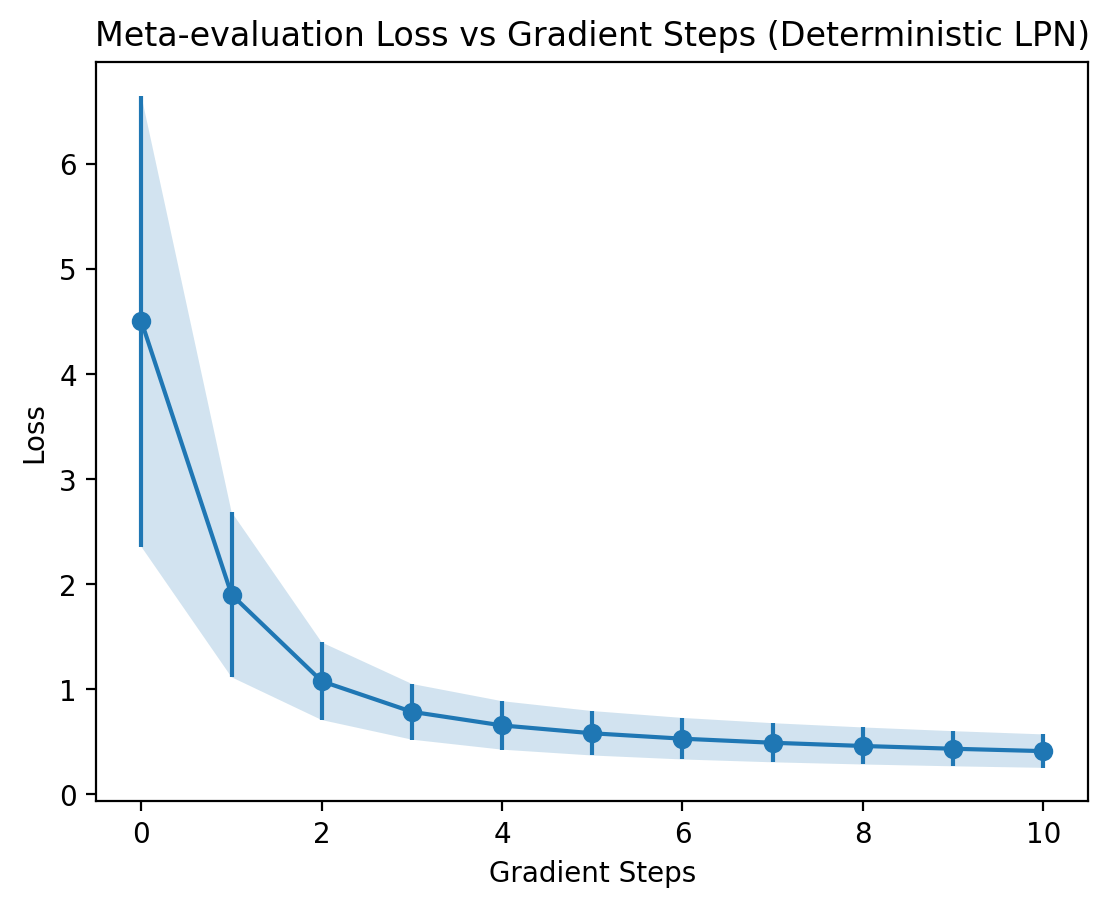

[[4.82446556e+01 1.68957367e+01 7.38411427e+00 4.89556599e+00
  4.14833355e+00 3.82201552e+00 3.63653064e+00 3.50099850e+00
  3.39014602e+00 3.29223728e+00 3.20362234e+00]
 [2.76013603e+01 6.61938429e+00 1.94013894e+00 8.28533649e-01
  5.01959682e-01 3.90156776e-01 3.41181874e-01 3.14649701e-01
  2.95526445e-01 2.80359000e-01 2.68164396e-01]
 [5.34255266e+00 6.92175508e-01 1.84458509e-01 1.71056613e-01
  1.93211377e-01 2.08081663e-01 2.17238814e-01 2.23717332e-01
  2.29004040e-01 2.33969271e-01 2.38848433e-01]
 [1.86473772e-01 1.34773389e-01 1.02311872e-01 8.31198245e-02
  7.20321760e-02 6.48429543e-02 5.99749200e-02 5.64799011e-02
  5.38444035e-02 5.17808795e-02 5.00858650e-02]
 [3.93351865e+00 2.41942191e+00 1.41939330e+00 8.40499401e-01
  5.04354477e-01 3.11685234e-01 2.08346367e-01 1.48839742e-01
  1.15188241e-01 9.80737135e-02 8.87138993e-02]
 [1.24038897e+01 1.94564378e+00 8.34459841e-01 6.49899602e-01
  5.83938658e-01 5.42381704e-01 5.08514643e-01 4.79711145e-01
  4.54397857e-01

In [91]:
metaeval_losses, metaeval_mu, metaeval_ci = evaluate_deterministic_lpn(lpn, device)
print(metaeval_losses)


In [92]:
print(metaeval_losses.shape)
print(metaeval_mu.shape)
print()
import pandas as pd
eval_df = pd.DataFrame({"mu": metaeval_mu, "ci": metaeval_ci})

eval_df.to_csv("..\\eval_data\LPN_eval_small.csv")

(60, 11)
(11,)



torch.sum(mse).item()=2.9814453125
torch.sum(mse).item()=1.911474347114563
torch.sum(mse).item()=1.286252737045288
torch.sum(mse).item()=0.9084852933883667
torch.sum(mse).item()=0.6786506772041321
torch.sum(mse).item()=0.5409398674964905
torch.sum(mse).item()=0.4429622292518616
torch.sum(mse).item()=0.3840286433696747
torch.sum(mse).item()=0.34708696603775024
torch.sum(mse).item()=0.32310280203819275
torch.sum(mse).item()=0.30617204308509827
torch.sum(mse).item()=0.2935335636138916
torch.sum(mse).item()=0.28428134322166443
torch.sum(mse).item()=0.27713343501091003
torch.sum(mse).item()=0.2713916301727295
torch.sum(mse).item()=0.26665183901786804
torch.sum(mse).item()=0.2626676857471466
torch.sum(mse).item()=0.2592795789241791
torch.sum(mse).item()=0.2563769817352295
torch.sum(mse).item()=0.253875732421875
torch.sum(mse).item()=0.25166791677474976
torch.sum(mse).item()=0.24975800514221191
torch.sum(mse).item()=0.24809886515140533
torch.sum(mse).item()=0.2466541826725006
torch.sum(mse).i

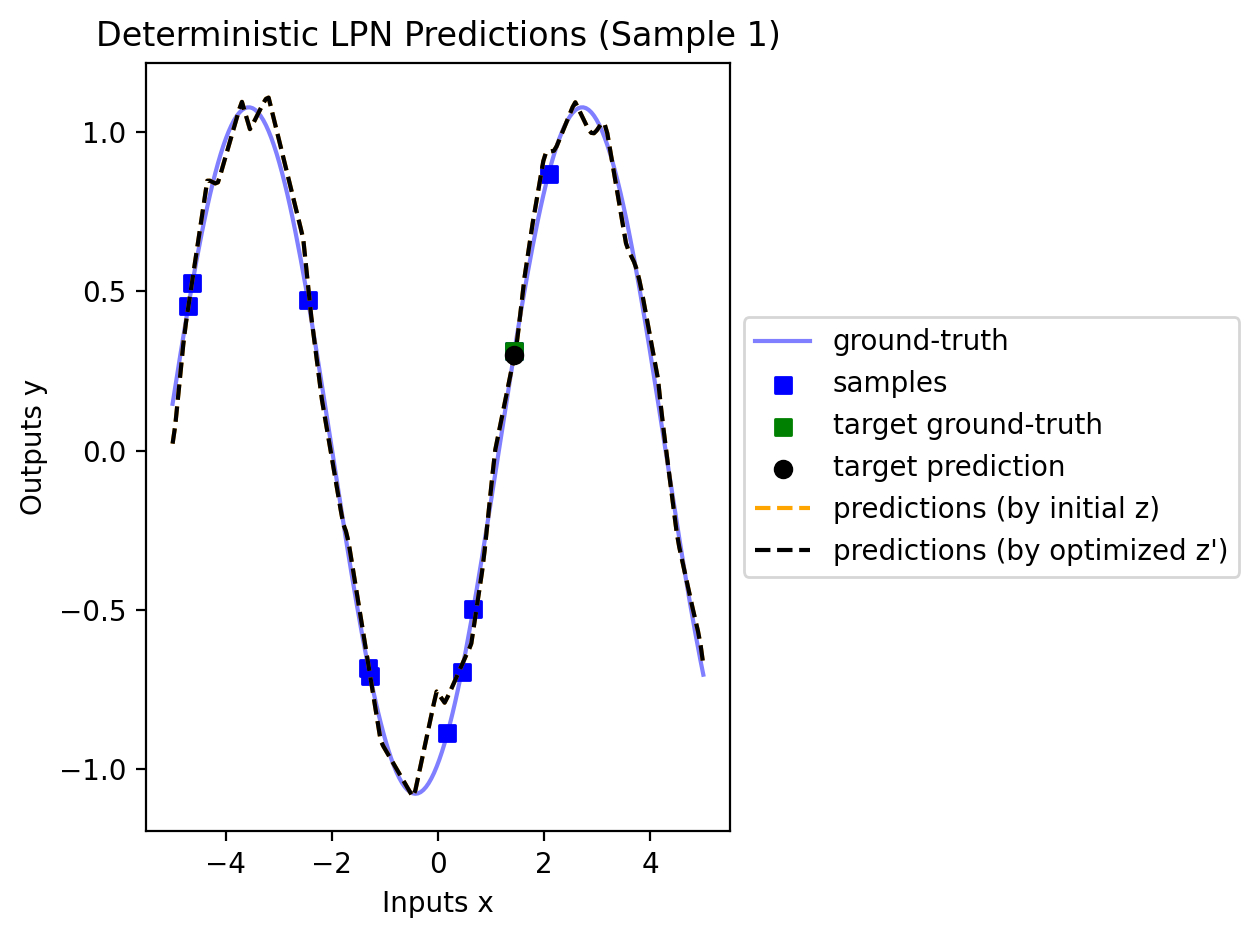

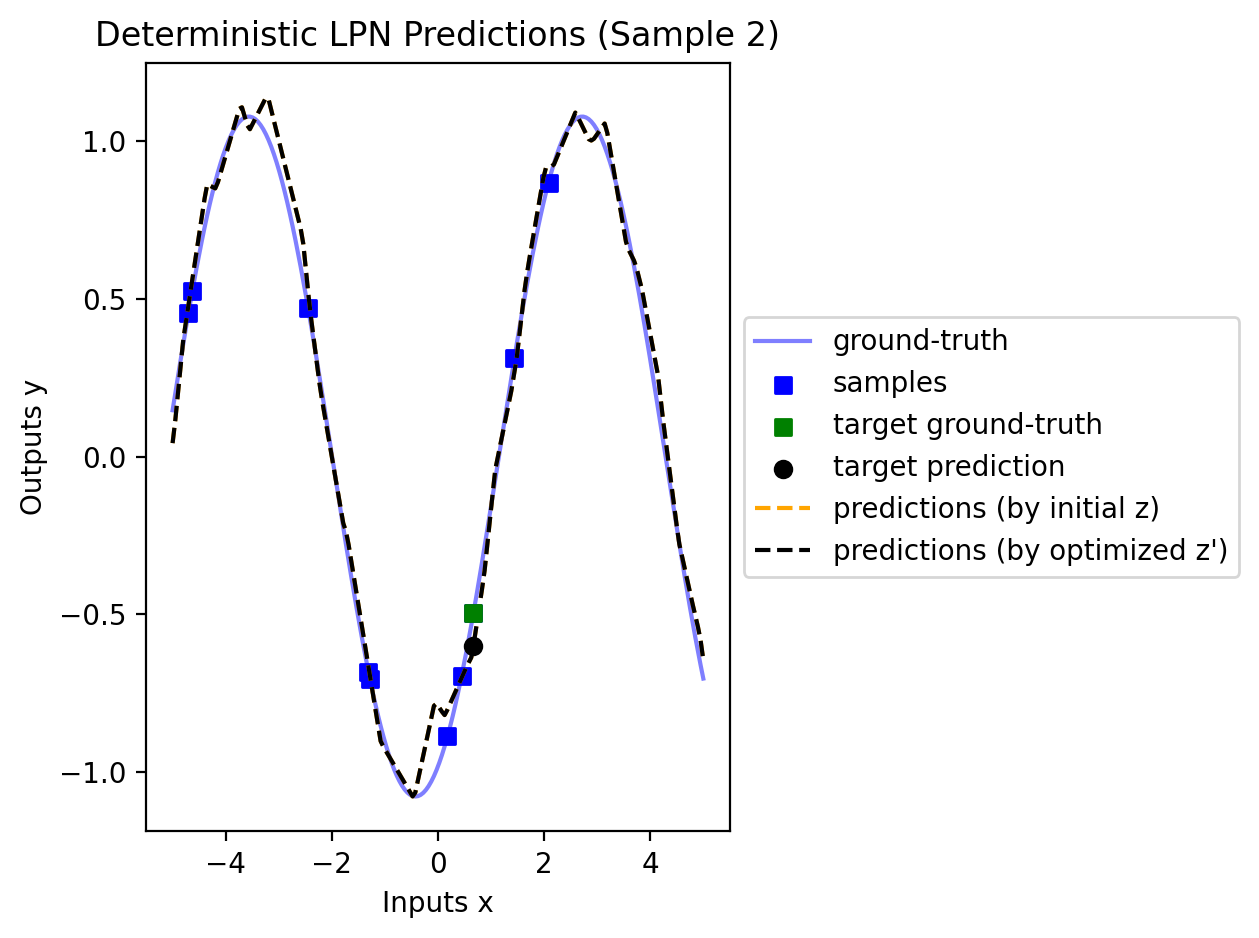

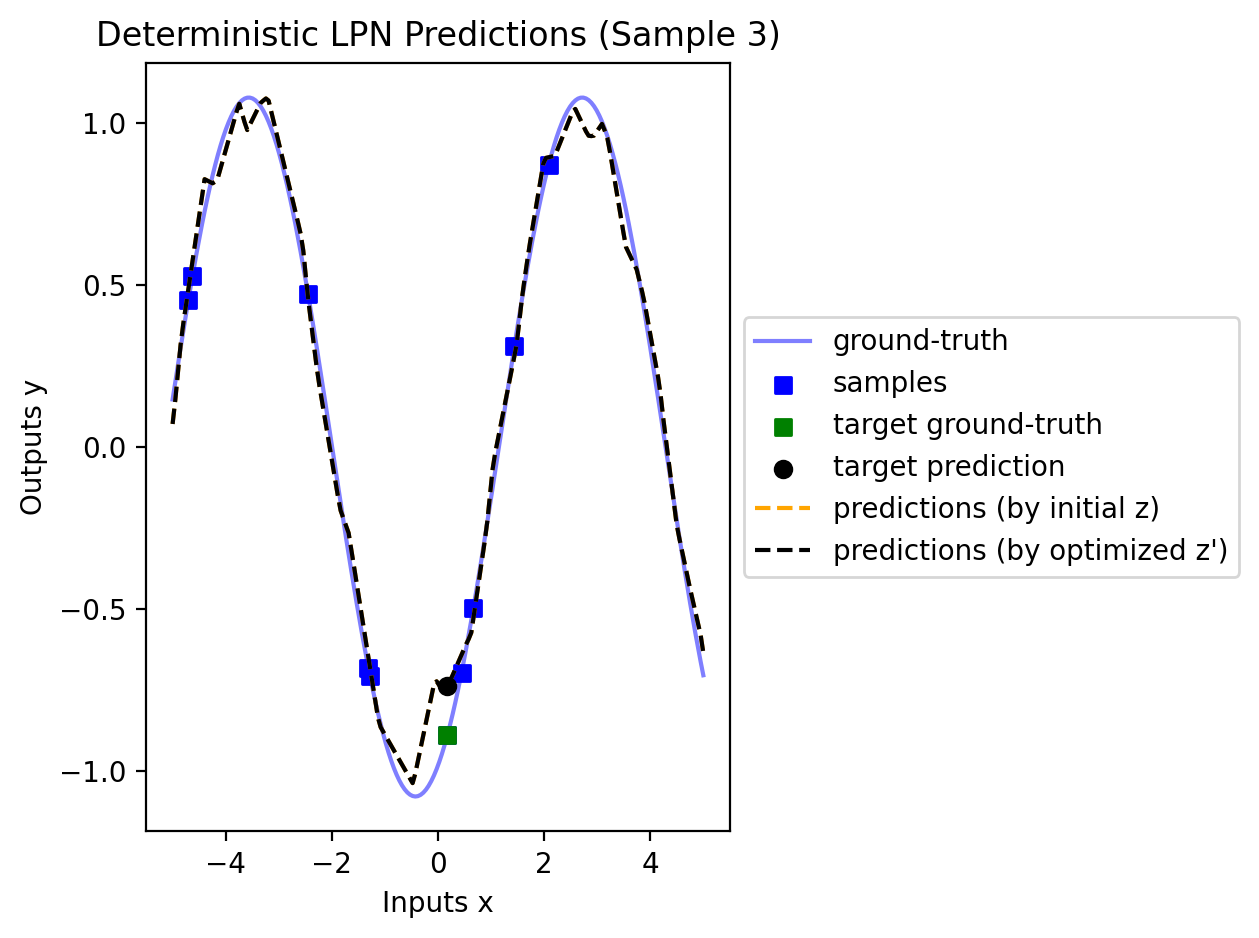

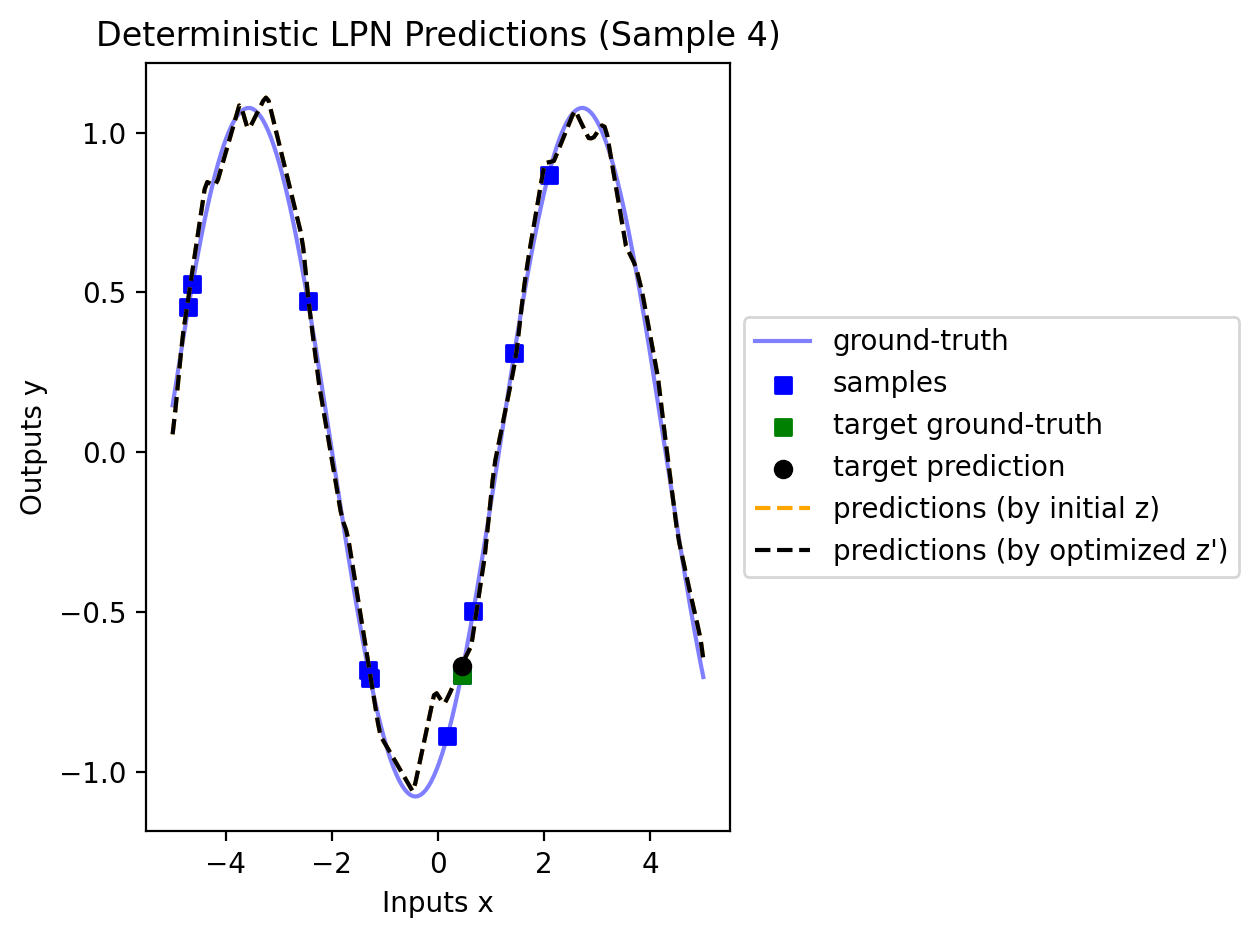

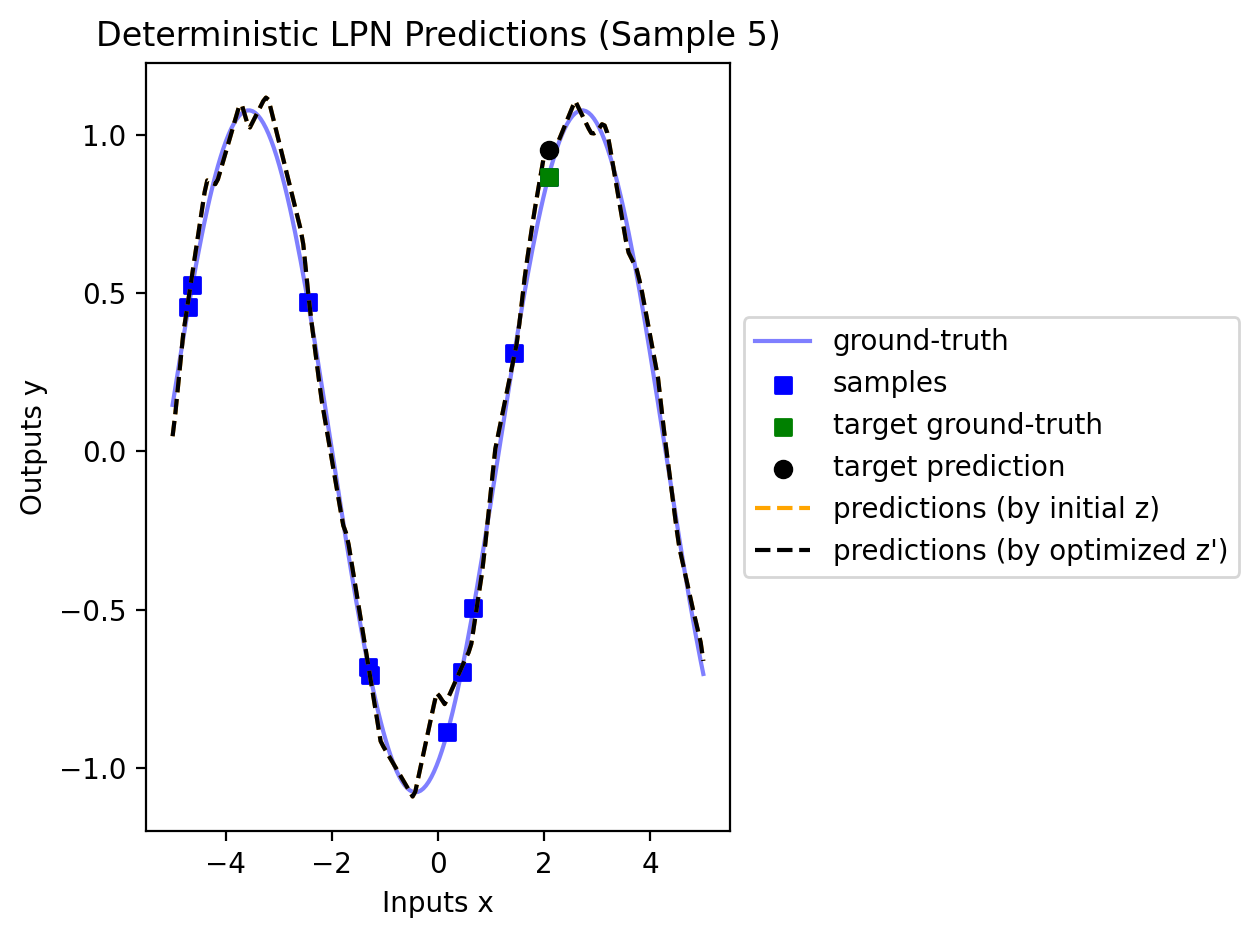

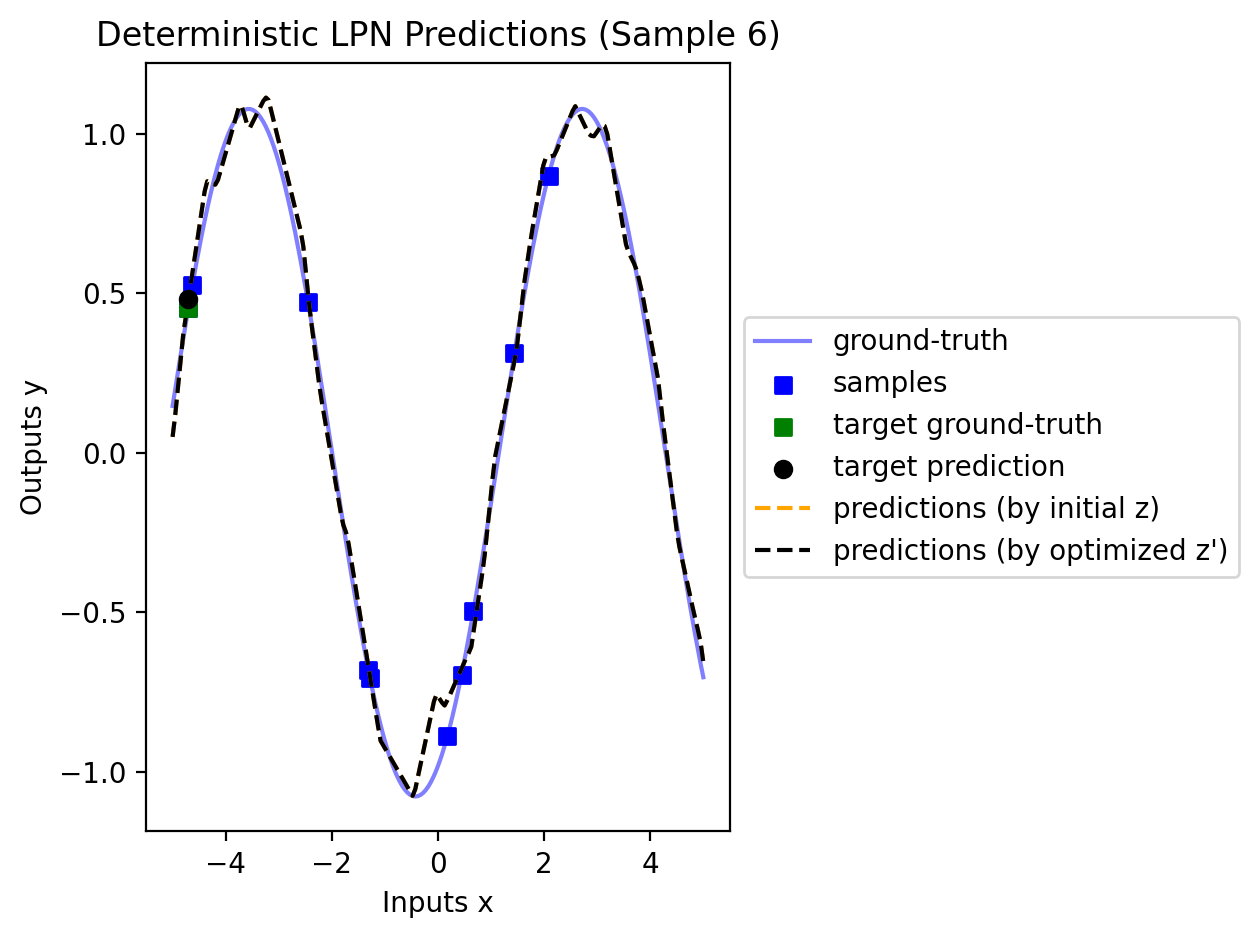

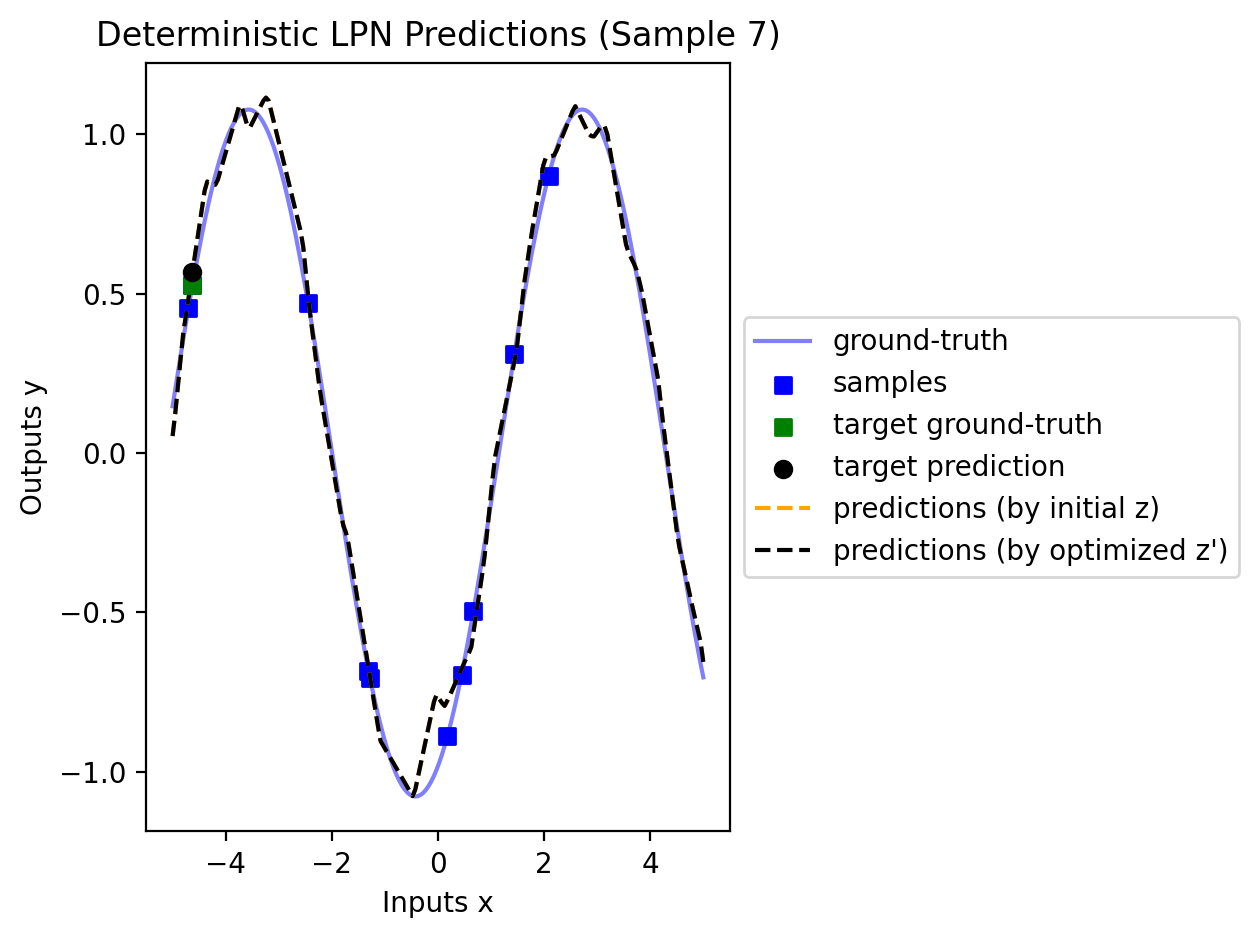

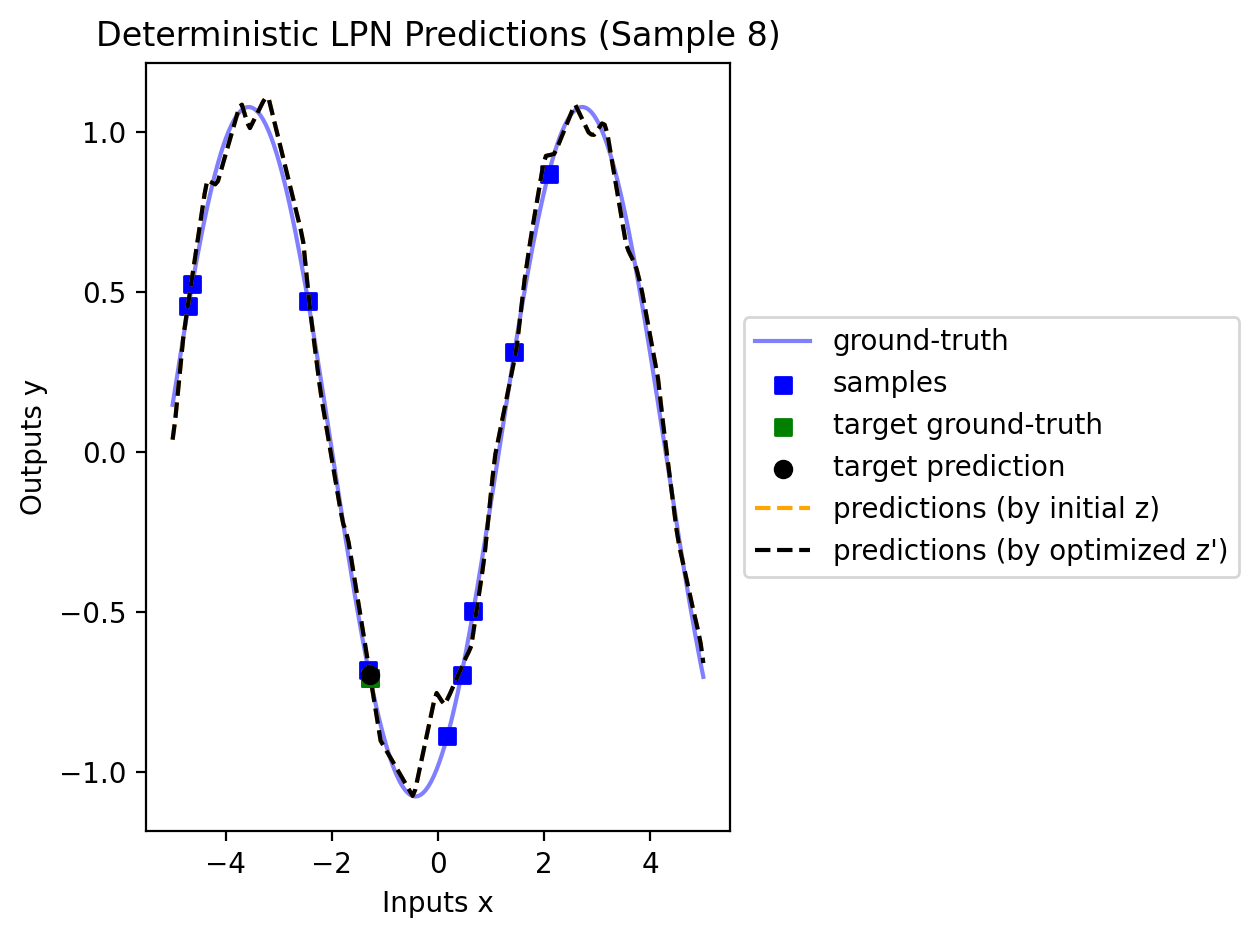

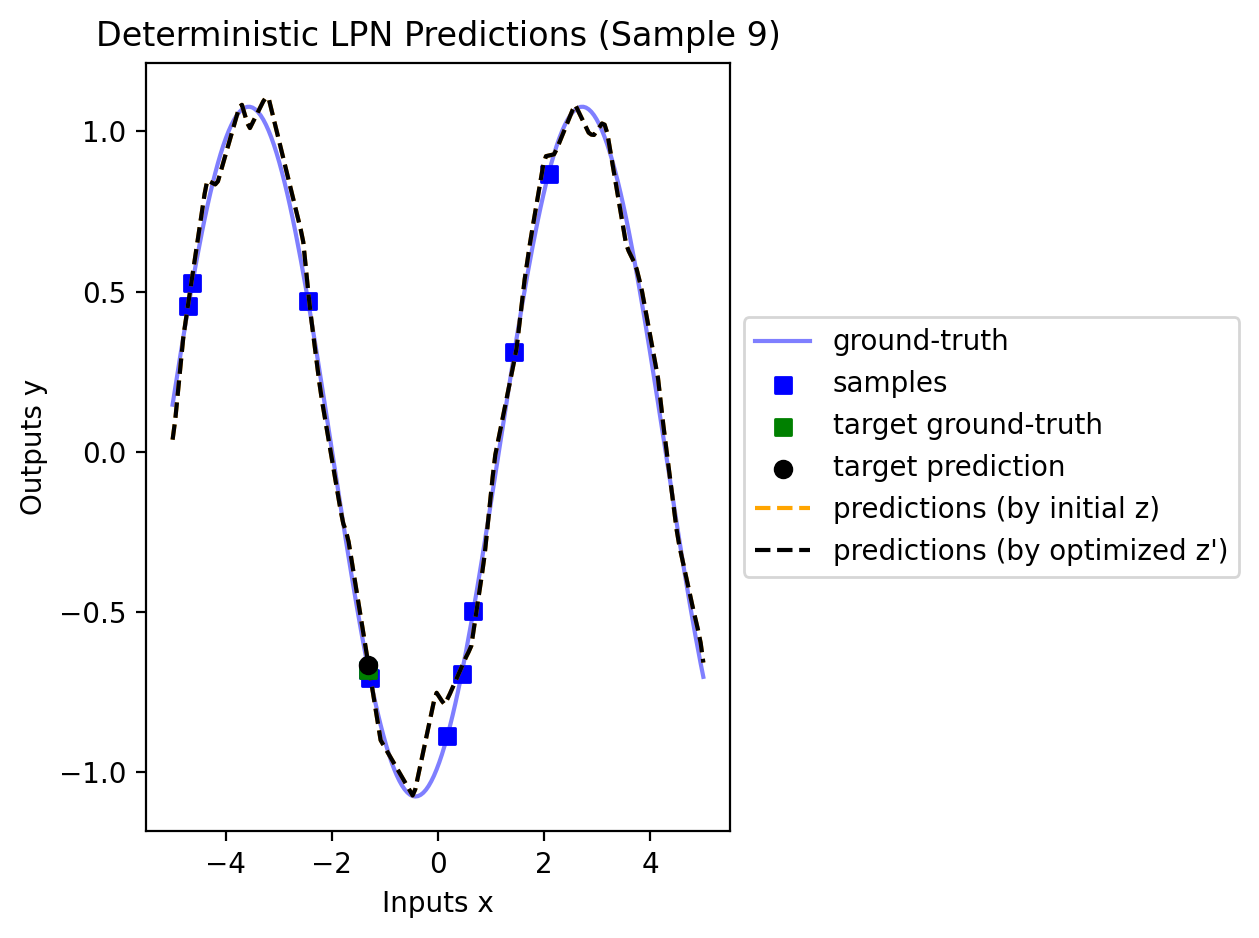

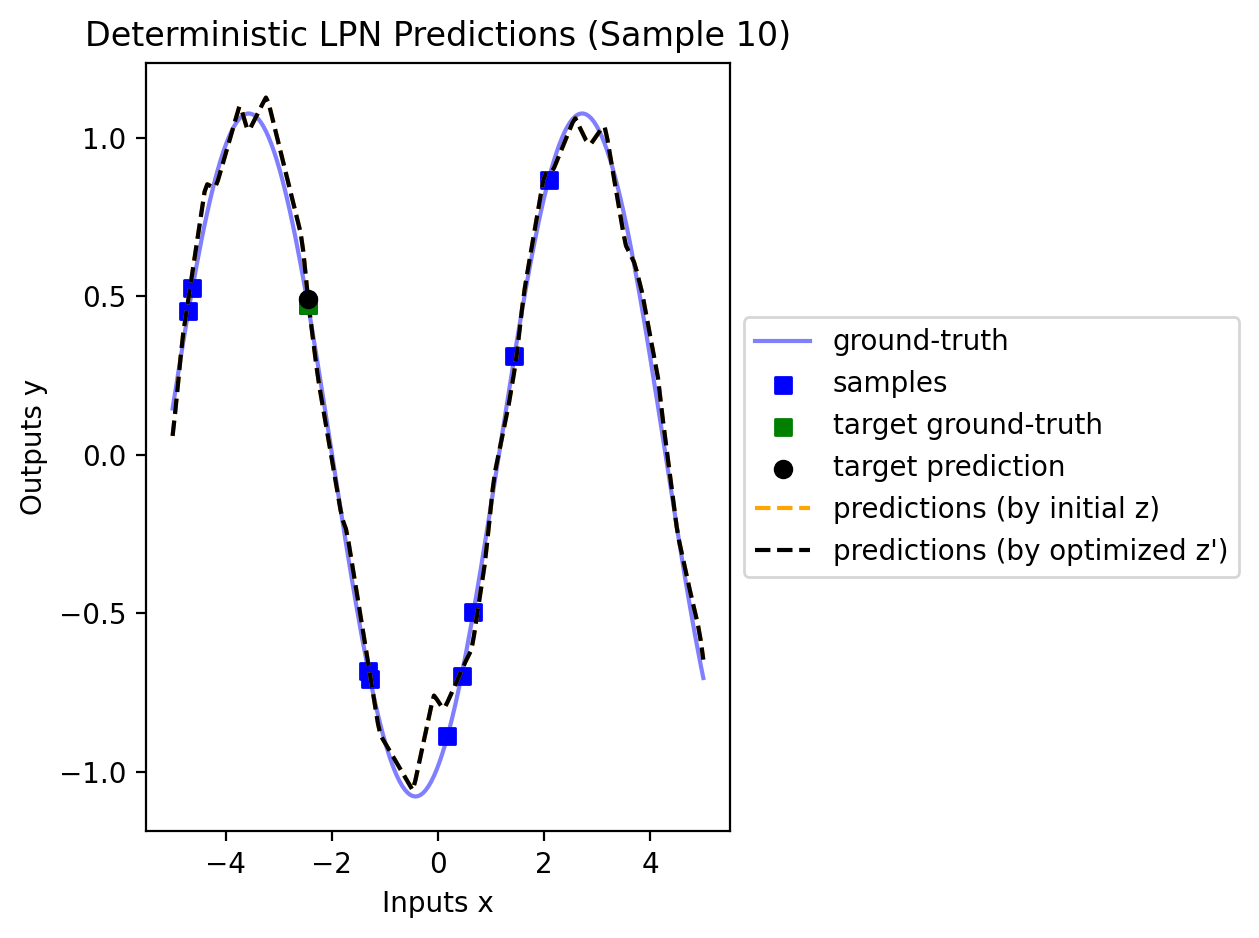

In [93]:
visualize_deterministic_lpn(lpn, device)